# Description

Analyze trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2

import logging
import os

import numpy as np
import pandas as pd

import core.finance as cofinanc
import core.plotting as coplotti
import core.statistics as costatis
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import market_data as mdata
import oms.ccxt.ccxt_filled_orders_reader as occforre
import oms.reconciliation as omreconc
import oms.target_position_and_order_generator as otpaorge

/app/core/signal_processing/decorrelation.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-8faa6abf-8a97-4f23-8432-d91eaa5bbcab.json'
-----------------------------------------------------------------------------
This code is not in sync with the container:
code_version='1.4.2' != container_version='1.4.0'
-----------------------------------------------------------------------------
You need to:
- merge origin/master into your branch with `invoke git_merge_master`
- pull the latest container with `invoke docker_pull`
INFO  # Git
  branch_name='CmTask4275_Check_how_we_load_OHLCV_data'
  hash='936a8f651'
  # Last commits:
    * 936a8f651 PomazkinG checkpoint                                                        ( 5 minutes ago) Sat May 20 16:13:22 2023  (HEAD -> CmTask4275_Check_how_we_load_OHLCV_data)
    *   9b4a182eb Grigorii Pomazkin Merge branch 'master' into CmTask4275_Check_how_we_load_OHLCV_data (16 minutes ago) Sat May 20 16:02:41 2023  (origin/CmTask4275_

# Config

In [3]:
# system_log_dir = "/shared_data/system_log_dir_20230323_20minutes/"
# system_log_dir = "/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230412/system_log_dir.scheduled.20230412_041000.20230412_080500"
# system_log_dir = "/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230413/system_log_dir.scheduled.20230413_143500.20230413_203000"
system_log_dir = "/app/system_log_dir/"
bar_duration = "5T"
id_col = "asset_id"
universe_version = "v7.1"

In [4]:
ccxt_log_reader = occforre.CcxtLogsReader(system_log_dir)

In [5]:
btc_ustd_id = 1467591036

In [6]:
use_historical = True

# Load Ccxt order responses and fills

In [7]:
data = ccxt_log_reader.load_all_data()
ccxt_order_response_df = data["ccxt_order_responses"]
fills_df = data["ccxt_trades"]
child_order_df = data["oms_child_orders"]

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230421/system_log_dir.scheduled.…

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230421/system_log_dir.scheduled.…

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230421/system_log_dir.scheduled.…

In [8]:
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,cost,average,filled,remaining,status,fee,trades,fees,order_response_timestamp,order_response_datetime
0,"{'orderId': '8383204249', 'symbol': 'APEUSDT',...",8383204249,x-xcKtGhcued7c3a02a3cc4e3af4d167,None,NaT,None,APE/USDT,limit,GTC,False,False,sell,4.084,NaN,7.0,28.588,4.084,7.0,0.0,closed,NaN,[],[],1682050241548,2023-04-21 04:10:41.548000+00:00
1,"{'orderId': '14684964755', 'symbol': 'AVAXUSDT...",14684964755,x-xcKtGhcud24c0f3d72b189a8ab2908,None,NaT,None,AVAX/USDT,limit,GTC,False,False,sell,18.394,NaN,1.0,18.397,18.397,1.0,0.0,closed,NaN,[],[],1682050243344,2023-04-21 04:10:43.344000+00:00
2,"{'orderId': '9024377538', 'symbol': 'AXSUSDT',...",9024377538,x-xcKtGhcu9621df2470507fd57e2a12,1682050245121,2023-04-21 04:10:45.121000+00:00,None,AXS/USDT,limit,GTC,False,False,buy,8.235,NaN,3.0,0.000,NaN,0.0,3.0,open,NaN,[],[],1682050245121,2023-04-21 04:10:45.121000+00:00


In [9]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2765 entries, 0 to 2764
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   info                      2765 non-null   object             
 1   order                     2765 non-null   int64              
 2   client_order_id           2765 non-null   string             
 3   timestamp                 1543 non-null   object             
 4   datetime                  1543 non-null   datetime64[ns, UTC]
 5   last_trade_timestamp      3 non-null      object             
 6   symbol                    2765 non-null   string             
 7   order_type                2765 non-null   string             
 8   time_in_force             2765 non-null   string             
 9   post_only                 2765 non-null   bool               
 10  reduce_only               2765 non-null   bool               
 11  side             

In [10]:
fills_df.head(3)

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count
timestamp,,,,,,,,,,,,,,,,,,,,,,
2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,APE/USDT,6051632686,367236696,8383204249,sell,taker,4.084,7.0,28.588,0.011435,USDT,0.0,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,0,1,1,0
2023-04-21 04:13:02.736000+00:00,2023-04-21 04:13:02.736000+00:00,2023-04-21 04:13:02.736000+00:00,APE/USDT,6051632686,367236778,8383210817,sell,taker,4.084,7.0,28.588,0.011435,USDT,0.0,2023-04-21 04:13:02.736000+00:00,2023-04-21 04:13:02.736000+00:00,2023-04-21 04:13:02.736000+00:00,2023-04-21 04:13:02.736000+00:00,0,1,1,0
2023-04-21 04:14:02.117000+00:00,2023-04-21 04:14:02.117000+00:00,2023-04-21 04:14:02.117000+00:00,APE/USDT,6051632686,367236799,8383213947,sell,taker,4.085,7.0,28.595,0.011438,USDT,0.0,2023-04-21 04:14:02.117000+00:00,2023-04-21 04:14:02.117000+00:00,2023-04-21 04:14:02.117000+00:00,2023-04-21 04:14:02.117000+00:00,0,1,1,0


In [11]:
fills_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1881 entries, 2023-04-21 04:10:41.548000+00:00 to 2023-04-21 06:49:39.654000+00:00
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         1881 non-null   datetime64[ns, UTC]
 1   datetime          1881 non-null   datetime64[ns, UTC]
 2   symbol            1881 non-null   object             
 3   asset_id          1881 non-null   int64              
 4   id                1881 non-null   int64              
 5   order             1881 non-null   int64              
 6   side              1881 non-null   object             
 7   takerOrMaker      1881 non-null   object             
 8   price             1881 non-null   float64            
 9   amount            1881 non-null   float64            
 10  cost              1881 non-null   float64            
 11  transaction_cost  1881 non-null   float64            
 12  

In [12]:
execution_has_btc = btc_ustd_id in fills_df["asset_id"]
_LOG.info("execution_has_btc=%s", execution_has_btc)

INFO  execution_has_btc=False


In [13]:
child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,limit_price,ccxt_id
order_id,,,,,,,,,,,,,,,,,,
24,2023-04-21 04:10:40.878863+00:00,6051632686,limit,2023-04-21 04:10:40.878863+00:00,2023-04-21 04:11:40.878863+00:00,0.0,-7.0,America/New_York,{'ccxt_id': 8383204249},0.55,4.083,4.084,4.083,4.084,latest_bid_price,latest_ask_price,4.08355,8383204249
25,2023-04-21 04:10:42.719932+00:00,8717633868,limit,2023-04-21 04:10:42.719932+00:00,2023-04-21 04:11:42.719932+00:00,0.0,-1.0,America/New_York,{'ccxt_id': 14684964755},0.55,18.393,18.394,18.393,18.394,latest_bid_price,latest_ask_price,18.39355,14684964755
26,2023-04-21 04:10:44.497362+00:00,2540896331,limit,2023-04-21 04:10:44.497362+00:00,2023-04-21 04:11:44.497362+00:00,0.0,3.0,America/New_York,{'ccxt_id': 9024377538},0.55,8.235,8.236,8.235,8.236,latest_bid_price,latest_ask_price,8.23545,9024377538


In [14]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2969 entries, 24 to 3737
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  2969 non-null   datetime64[ns, UTC]
 1   asset_id            2969 non-null   int64              
 2   type_               2969 non-null   object             
 3   start_timestamp     2969 non-null   datetime64[ns, UTC]
 4   end_timestamp       2969 non-null   datetime64[ns, UTC]
 5   curr_num_shares     2969 non-null   float64            
 6   diff_num_shares     2969 non-null   float64            
 7   tz                  2969 non-null   object             
 8   extra_params        2969 non-null   object             
 9   passivity_factor    2969 non-null   float64            
 10  latest_bid_price    2969 non-null   float64            
 11  latest_ask_price    2969 non-null   float64            
 12  bid_price_mean      2969 non-null   fl

## Aggregate by order and bar

In [15]:
# TODO(Paul): Look into adding tqdm.
# Aggregate order responses by bar.
bar_ccxt_order_aggregation = occforre.aggregate_ccxt_orders_by_bar(
    ccxt_order_response_df, bar_duration
)
# Aggregate fills by order.
ccxt_order_fills = occforre.aggregate_fills_by_order(fills_df)
# Aggregate fills by bar.
bar_fills = occforre.aggregate_fills_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate buy/sell trade prices by bar.
trade_prices = occforre.compute_buy_sell_prices_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)

In [16]:
bar_ccxt_order_aggregation.head(3)

order_count                                                                                                                                                                                                                                                                         buy_order_count                                                                                                                                                                                                                                                                         buy_limit_twap                                                                                                                                                                                                                                                                         buy_limit_vwap                                                                                                                           \
asset_id                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-21 04:15:00+00:00           4          4          4          0          4          4          0          4          0          4          4          0          4          4          4          4          4          0          4          4          4          4          4          4          4               4          4          0          0          0          0          0          4          0          0          4          0          0          4          0          4          4          0          4          4          0          0          0          4          0       0.347575     1944.6        NaN        NaN        NaN        NaN        NaN    1.49925        NaN        NaN   0.377350        NaN        NaN      8.236        NaN     1.0518   0.084038        NaN   0.618025   0.772075        NaN        NaN        NaN   319.7425        NaN       0.347575     1944.6        NaN        NaN        NaN        NaN        NaN    1.49925        NaN        NaN   0.377350        NaN   
2023-04-21 04:20:00+00:00 

In [17]:
ccxt_order_fills.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,
2152629635,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,CTK/USDT,5115052901,1,0,1,0,0.7721,82.0,63.3122,0.025325,0.0000
2152634069,2023-04-21 04:17:32.062000+00:00,2023-04-21 04:17:32.062000+00:00,2023-04-21 04:17:32.062000+00:00,2023-04-21 04:17:32.062000+00:00,CTK/USDT,5115052901,0,1,1,0,0.7721,74.0,57.1354,0.022854,0.0037
2152634702,2023-04-21 04:18:32.899000+00:00,2023-04-21 04:18:32.899000+00:00,2023-04-21 04:18:32.899000+00:00,2023-04-21 04:18:32.899000+00:00,CTK/USDT,5115052901,0,1,1,0,0.7725,74.0,57.1650,0.022866,0.0333


In [18]:
bar_fills.head(3)

first_timestamp                   last_timestamp                   first_datetime                    last_datetime     symbol    asset_id  buy_count  sell_count  taker_count  maker_count         price  amount       cost  transaction_cost  realized_pnl
bar_end_datetime          asset_id                                                                                                                                                                                                                                                                               
2023-04-21 04:15:00+00:00 1464553467 2023-04-21 04:11:01.274000+00:00 2023-04-21 04:13:52.989000+00:00 2023-04-21 04:11:01.274000+00:00 2023-04-21 04:13:52.989000+00:00   ETH/USDT  1464553467          5           0            4            1   1944.583333   0.261  507.53625          0.169179           0.0
                          1467591036 2023-04-21 04:14:05.202000+00:00 2023-04-21 04:14:11.060000+00:00 2023-04-21 04:14:05.202000+00:00 2023-04-21 04:14:11.060000+00:00   BTC/USDT  1467591036          0           4            3            1  28313.150000   0.010  283.13150          0.084943           0.0
                          1776791608 2023-04-21 04:12:07.623000+00:00 2023-04-21 04:14:38.240000+00:00 2023-04-21 04:12:07.623000+00:00 2023-04-21 04:14:38.240000+00:00  UNFI/USDT  1776791608          0           4            3            1      5.063750   6.400   32.40800          0.011343           0.0

In [19]:
trade_prices.head(3)

buy_trade_price                                                                                                                                                                                                                                                                               sell_trade_price                                                                                                                                                                                                                                                                        
asset_id                       1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2023-04-21 04:15:00+00:00             NaN  1944.583333           NaN        NaN        NaN        NaN        NaN        1.5        NaN        NaN    0.37725        NaN        NaN      8.237        NaN   1.051867    0.08405        NaN      0.618     0.7721        NaN        NaN        NaN  319.790667        NaN              NaN        NaN   28313.15        NaN    5.06375   6.142000        NaN        NaN        NaN   2.023133        NaN        NaN     0.1178        NaN   7.545667        NaN        NaN        NaN        NaN        NaN   0.477825   4.084333       18.4        NaN   2.054667
2023-04-21 04:20:00+00:00             NaN          NaN  28308.266667    0.19695   5.060333        NaN        NaN        NaN        NaN     2.0229        NaN        NaN        NaN        NaN     7.5515        NaN        NaN        NaN        NaN        NaN     0.4781      4.084        NaN         NaN      2.054              NaN   1945.605        NaN        NaN        NaN   6.143667     0.4681   1.500667        NaN        NaN   0.377367        NaN        NaN     8.2475        NaN   1.053133   0.084130   2.711333   0.618825   0.772333        NaN        NaN        NaN   319.8252        NaN
2023-04-21 04:25:00+00:00             NaN          NaN  28294.950000    0.19690        NaN        NaN        NaN        NaN        NaN        NaN    0.37720        NaN        NaN      8.251        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN        NaN  319.800000        NaN              NaN   1945.970        NaN        NaN        NaN        NaN        NaN        NaN        NaN   2.024550        NaN        NaN        NaN        NaN        NaN   1.054014   0.084283   2.713000   0.619425        NaN        NaN   4.086250        NaN        NaN   2.057333

In [20]:
if execution_has_btc:
    omreconc.get_asset_slice(bar_ccxt_order_aggregation, btc_asset_id)

In [21]:
# If `order_twap` and `order_vwap` are different for a given instrument and bar,
#  then we are likely submitting orders of differing sizes.
# Use rounding to ignore machine precision artifacts.
#
# If this number is not zero, then closely inspect the dataframe (without summing
# absolute values).
bar_ccxt_order_aggregation["buy_limit_twap"].subtract(
    bar_ccxt_order_aggregation["buy_limit_vwap"]
).abs().sum().sum().round(9)

0.0

In [22]:
# Analogous check but for sells.
bar_ccxt_order_aggregation["sell_limit_twap"].subtract(
    bar_ccxt_order_aggregation["sell_limit_vwap"]
).abs().sum().sum().round(9)

0.0

### Cross-checks

In [23]:
# For a given bar and a given instrument, we expect to see either 0 (child) orders, or X child orders,
# where X is constant across the run.
# This should have counts for two values: zero and the number X of trades per bar.
bar_ccxt_order_aggregation["order_count"].stack().value_counts()

4    674
0    126
3     19
2      6
dtype: int64

#### Cross-checking the missing order count for bars

The correct number of child orders expected to be submitted for a bar is 4 per asset_id (if there is a planned submission), or 0 per asset_id (if no orders are planned to be submitted or the order notional is too small for the exchange to accept the order.

In [24]:
# Get all bars and asset_ids with inconsistent child order number.
inconsistent_order_num_df = bar_ccxt_order_aggregation["order_count"].stack()[
    ~bar_ccxt_order_aggregation["order_count"].stack().isin([0, 4])
]
inconsistent_order_num_df

bar_end_datetime           asset_id  
2023-04-21 06:45:00+00:00  4516629366    3
2023-04-21 06:50:00+00:00  8717633868    3
2023-04-21 06:55:00+00:00  1030828978    3
                           1464553467    3
                           1467591036    3
                           1528092593    3
                           1776791608    2
                           1891737434    3
                           1966583502    3
                           2099673105    2
                           2237530510    3
                           2384892553    3
                           2425308589    3
                           2476706208    3
                           2484635488    2
                           2540896331    3
                           2601760471    3
                           2683705052    3
                           3065029174    2
                           3401245610    3
                           4516629366    2
                           5115052901    2
                

- Most of the 2- and 3-children order submissions happen at the last bar, where there is a strict time cutoff which does not let the child orders to finish submission.

In [25]:
# Get all orders for the bars in the range where the numbers have been inconsistent.
# Note: may yield uninterpretable results if the bars are not consecutive.
if False:
    child_order_df[
        (
            child_order_df["creation_timestamp"]
            > inconsistent_order_num_df.index.min()[0]
        )
        & (
            child_order_df["creation_timestamp"]
            < inconsistent_order_num_df.index.max()[0]
        )
        & (child_order_df["asset_id"].isin(inconsistent_order_num_df.index[1]))
    ]

#### Check child orders with no corresponding exchange responses

In [26]:
_LOG.info(
    f"child orders in child_order_df={child_order_df.shape[0]}\nresponses in ccxt_order_response_df={ccxt_order_response_df.shape[0]}\n\
child_order_df-ccxt_order_response_df={child_order_df.shape[0]-ccxt_order_response_df.shape[0]}"
)

INFO  child orders in child_order_df=2969
responses in ccxt_order_response_df=2765
child_order_df-ccxt_order_response_df=204


In [27]:
# Get child orders that were generated but did not get an order response.
no_response_orders = child_order_df[child_order_df["ccxt_id"] == -1]
no_response_orders["error_msg"] = no_response_orders["extra_params"].apply(
    lambda x: eval(x).get("error_msg", "")
)

In [28]:
# Check the error messages for child orders that did not come through.
no_response_orders["error_msg"].value_counts()

binance {"code":-4164,"msg":"Order's notional must be no smaller than 5.0 (unless you choose reduce only)"}    196
                                                                                                                 8
Name: error_msg, dtype: int64

In [29]:
# Not all error messages are logged as of now, check child orders with no response and no logged error message.
no_response_orders[no_response_orders["error_msg"] == ""]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,limit_price,ccxt_id,error_msg
order_id,,,,,,,,,,,,,,,,,,,
3488,2023-04-21 06:42:31.987633+00:00,4516629366,limit,2023-04-21 06:42:31.987633+00:00,2023-04-21 06:43:31.987633+00:00,280.0,79.0,America/New_York,{},0.55,0.61180,0.61190,0.611885,0.611985,latest_bid_price,latest_ask_price,0.611845,-1,
3621,2023-04-21 06:48:37.170624+00:00,8717633868,limit,2023-04-21 06:48:37.170624+00:00,2023-04-21 06:49:37.170624+00:00,1.0,2.0,America/New_York,{},0.55,18.01600,18.01700,18.016195,18.017268,latest_bid_price,latest_ask_price,18.016450,-1,
3719,2023-04-21 06:53:09.082905+00:00,1776791608,limit,2023-04-21 06:53:09.082905+00:00,2023-04-21 06:54:09.082905+00:00,11.7,-2.9,America/New_York,{},0.55,4.98100,4.98200,4.979175,4.980500,latest_bid_price,latest_ask_price,4.981550,-1,
3722,2023-04-21 06:53:17.473193+00:00,2099673105,limit,2023-04-21 06:53:17.473193+00:00,2023-04-21 06:54:17.473193+00:00,65.0,-68.0,America/New_York,{},0.55,1.47000,1.47100,1.470775,1.471800,latest_bid_price,latest_ask_price,1.470550,-1,
3727,2023-04-21 06:53:29.331924+00:00,2484635488,limit,2023-04-21 06:53:29.331924+00:00,2023-04-21 06:54:29.331924+00:00,871.0,544.0,America/New_York,{},0.55,0.11540,0.11550,0.115384,0.115487,latest_bid_price,latest_ask_price,0.115445,-1,
3731,2023-04-21 06:53:39.903206+00:00,3065029174,limit,2023-04-21 06:53:39.903206+00:00,2023-04-21 06:54:39.903206+00:00,385.0,330.0,America/New_York,{},0.55,0.08324,0.08325,0.083275,0.083285,latest_bid_price,latest_ask_price,0.083244,-1,
3733,2023-04-21 06:53:46.444810+00:00,4516629366,limit,2023-04-21 06:53:46.444810+00:00,2023-04-21 06:54:46.444810+00:00,76.0,82.0,America/New_York,{},0.55,0.60710,0.60720,0.606926,0.607033,latest_bid_price,latest_ask_price,0.607145,-1,
3734,2023-04-21 06:53:51.211125+00:00,5115052901,limit,2023-04-21 06:53:51.211125+00:00,2023-04-21 06:54:51.211125+00:00,338.0,-170.0,America/New_York,{},0.55,0.75900,0.75910,0.758963,0.759158,latest_bid_price,latest_ask_price,0.759055,-1,


In [30]:
# If `buy_count` and `sell_count` are both greater than zero for an order,
#  there is a problem.
has_buys = ccxt_order_fills["buy_count"] > 0
has_sells = ccxt_order_fills["sell_count"] > 0
# This dataframe should have zero rows.
ccxt_order_fills.loc[has_buys & has_sells].shape[0]

0

In [31]:
# If `buy_count` and `sell_count` are both greater than zero for an instrument and bar,
#  there is likely a bar alignment or timing problem.
has_buys = bar_fills["buy_count"] > 0
has_sells = bar_fills["sell_count"] > 0
# This dataframe should be empty.
bar_fills.loc[has_buys & has_sells].shape[0]

4

In [32]:
# TODO(Paul): This plotting function applies here too, even though we are working with counts
#  instead of slippage. Rename and move the plotting function.
# TODO(Paul): This plotting function doesn't seem to be idempotent.
# col = "order_count"
# coplotti.plot_slippage_boxplot(bar_ccxt_order_aggregation[col], "by_time", ylabel=col)

In [33]:
# TODO(Paul): This plotting function applies here too, even though we are working with counts
#  instead of slippage. Rename and move the plotting function.
# col = "order_count"
# coplotti.plot_slippage_boxplot(bar_ccxt_order_aggregation[col], "by_asset", ylabel=col)

## Fee summary

In [34]:
order_fees = fills_df["transaction_cost"].sum()
_LOG.info("Cumulative order fees in dollars=%f" % order_fees)

INFO  Cumulative order fees in dollars=24.086007


In [35]:
traded_dollar_volume = fills_df["cost"].sum()
_LOG.info("Cumulative turnover in dollars=%f", traded_dollar_volume)

INFO  Cumulative turnover in dollars=69738.968380


In [36]:
order_fees_in_bps = 1e4 * order_fees / traded_dollar_volume
_LOG.info("Cumulative order fees in bps=%f", order_fees_in_bps)

INFO  Cumulative order fees in bps=3.453737


In [37]:
realized_pnl = fills_df["realized_pnl"].sum()
_LOG.info("Realized gross pnl in dollars=%f", realized_pnl)

INFO  Realized gross pnl in dollars=0.561679


In [38]:
realized_pnl_in_bps = 1e4 * realized_pnl / traded_dollar_volume
_LOG.info("Realized gross pnl in bps=%f", realized_pnl_in_bps)

INFO  Realized gross pnl in bps=0.080540


## Align ccxt orders and fills

In [39]:
filled_ccxt_orders, unfilled_ccxt_orders = occforre.align_ccxt_orders_and_fills(
    ccxt_order_response_df, fills_df
)

In [40]:
filled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_response_timestamp,order_response_datetime,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,,,
8383204249,limit,GTC,False,False,sell,4.0840,NaN,7.0,1682050241548,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,2023-04-21 04:10:41.548000+00:00,APE/USDT,6051632686,0,1,1,0,4.0840,7.0,28.5880,0.011435,0.0
14684964755,limit,GTC,False,False,sell,18.3940,NaN,1.0,1682050243344,2023-04-21 04:10:43.344000+00:00,2023-04-21 04:10:43.344000+00:00,2023-04-21 04:10:43.344000+00:00,2023-04-21 04:10:43.344000+00:00,2023-04-21 04:10:43.344000+00:00,AVAX/USDT,8717633868,0,1,1,0,18.3970,1.0,18.3970,0.007359,0.0
2152629635,limit,GTC,False,False,buy,0.7723,NaN,82.0,1682050254110,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,2023-04-21 04:10:54.110000+00:00,CTK/USDT,5115052901,1,0,1,0,0.7721,82.0,63.3122,0.025325,0.0


In [41]:
unfilled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_response_timestamp,order_response_datetime
order,,,,,,,,,,
2152630141,limit,GTC,False,False,buy,0.772,NaN,82.0,1682050334459,2023-04-21 04:12:14.459000+00:00
2152630518,limit,GTC,False,False,buy,0.772,NaN,82.0,1682050395274,2023-04-21 04:13:15.274000+00:00
2152631105,limit,GTC,False,False,buy,0.772,NaN,82.0,1682050454614,2023-04-21 04:14:14.614000+00:00


In [42]:
filled_order_execution_quality = occforre.compute_filled_order_execution_quality(
    filled_ccxt_orders, tick_decimals=6
)
filled_order_execution_quality.head()

,direction,price_improvement_notional,price_improvement_bps,underfill_quantity,underfill_pct,underfill_notional_at_limit_price,underfill_notional_at_transaction_price
order,,,,,,,
8383204249,-1,0.0000,0.000000,0.0,0.0,0.0,0.0
14684964755,-1,0.0030,1.630967,0.0,0.0,0.0,0.0
2152629635,1,0.0002,2.589667,0.0,0.0,0.0,0.0
8389765593846380207,1,0.2400,1.233959,0.0,0.0,0.0,0.0
25417264111,1,0.0001,0.950480,0.0,0.0,0.0,0.0


In [43]:
# If any value is negative (up to machine precision), except for `direction`, there is a bug somewhere.
filled_order_execution_quality.loc[
    (filled_order_execution_quality.drop("direction", axis=1).round(9) < 0).any(
        axis=1
    )
].shape[0]

0

In [44]:
filled_order_execution_quality.min()

direction                                 -1.000000e+00
price_improvement_notional                 0.000000e+00
price_improvement_bps                      0.000000e+00
underfill_quantity                        -7.105427e-15
underfill_pct                             -1.515016e-16
underfill_notional_at_limit_price         -1.424496e-14
underfill_notional_at_transaction_price   -1.424908e-14
dtype: float64

In [45]:
filled_order_execution_quality.max()

direction                                    1.000000
price_improvement_notional                  85.900000
price_improvement_bps                       66.026411
underfill_quantity                         168.000000
underfill_pct                                0.928571
underfill_notional_at_limit_price           83.148000
underfill_notional_at_transaction_price     83.148000
dtype: float64

# Load internal parent and child orders

These are in the internal `amp` format (not the `ccxt` format)

In [46]:
parent_order_df = ccxt_log_reader.load_oms_parent_order_df()

Loading `orders` files...:   0%|          | 0/32 [00:00<?, ?it/s]

In [47]:
parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2023-04-21 04:10:38.700321+00:00,6051632686,price@custom_twap,2023-04-21 04:10:38.700321+00:00,2023-04-21 04:15:00+00:00,0.0,-28.0,America/New_York,{}
1,2023-04-21 04:10:38.700321+00:00,8717633868,price@custom_twap,2023-04-21 04:10:38.700321+00:00,2023-04-21 04:15:00+00:00,0.0,-5.0,America/New_York,{}
2,2023-04-21 04:10:38.700321+00:00,2540896331,price@custom_twap,2023-04-21 04:10:38.700321+00:00,2023-04-21 04:15:00+00:00,0.0,12.0,America/New_York,{}


In [48]:
parent_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 3557
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  746 non-null    datetime64[ns, UTC]
 1   asset_id            746 non-null    object             
 2   type_               746 non-null    object             
 3   start_timestamp     746 non-null    datetime64[ns, UTC]
 4   end_timestamp       746 non-null    datetime64[ns, UTC]
 5   curr_num_shares     746 non-null    object             
 6   diff_num_shares     746 non-null    object             
 7   tz                  746 non-null    object             
 8   extra_params        746 non-null    object             
dtypes: datetime64[ns, UTC](3), object(6)
memory usage: 58.3+ KB


In [49]:
number_of_bars = int(
    np.ceil(
        (
            parent_order_df["end_timestamp"].max()
            - parent_order_df["start_timestamp"].min()
        )
        / bar_duration
    )
)
_LOG.info("number of bars=%d", number_of_bars)

INFO  number of bars=32


In [50]:
unique_asset_id_count = len(parent_order_df["asset_id"].unique())
_LOG.info("unique asset_id count=%d", unique_asset_id_count)

INFO  unique asset_id count=25


In [51]:
# Share counts should change if there are many orders and we are getting fills.
costatis.compute_moments(parent_order_df["curr_num_shares"])

mean         12.956521
std         254.935628
skew          0.861979
kurtosis     29.031496
Name: curr_num_shares, dtype: float64

In [52]:
child_order_df = ccxt_log_reader.load_oms_child_order_df()

Loading `/shared_data/ecs/preprod/twap_experiment/system_reconciliation/C3a/20230421/system_log_dir.scheduled.…

In [53]:
child_order_df.head()

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,passivity_factor,latest_bid_price,latest_ask_price,bid_price_mean,ask_price_mean,used_bid_price,used_ask_price,limit_price,ccxt_id
order_id,,,,,,,,,,,,,,,,,,
24,2023-04-21 04:10:40.878863+00:00,6051632686,limit,2023-04-21 04:10:40.878863+00:00,2023-04-21 04:11:40.878863+00:00,0.0,-7.00,America/New_York,{'ccxt_id': 8383204249},0.55,4.0830,4.0840,4.0830,4.0840,latest_bid_price,latest_ask_price,4.083550,8383204249
25,2023-04-21 04:10:42.719932+00:00,8717633868,limit,2023-04-21 04:10:42.719932+00:00,2023-04-21 04:11:42.719932+00:00,0.0,-1.00,America/New_York,{'ccxt_id': 14684964755},0.55,18.3930,18.3940,18.3930,18.3940,latest_bid_price,latest_ask_price,18.393550,14684964755
26,2023-04-21 04:10:44.497362+00:00,2540896331,limit,2023-04-21 04:10:44.497362+00:00,2023-04-21 04:11:44.497362+00:00,0.0,3.00,America/New_York,{'ccxt_id': 9024377538},0.55,8.2350,8.2360,8.2350,8.2360,latest_bid_price,latest_ask_price,8.235450,9024377538
27,2023-04-21 04:10:46.275766+00:00,1528092593,limit,2023-04-21 04:10:46.275766+00:00,2023-04-21 04:11:46.275766+00:00,0.0,21.00,America/New_York,"{'error_msg': 'binance {""code"":-4164,""msg"":""Or...",0.55,0.1971,0.1972,0.1971,0.1972,latest_bid_price,latest_ask_price,0.197145,-1
28,2023-04-21 04:10:48.044750+00:00,8968126878,limit,2023-04-21 04:10:48.044750+00:00,2023-04-21 04:11:48.044750+00:00,0.0,0.28,America/New_York,{'ccxt_id': 46246954300},0.55,319.6600,319.6700,319.6600,319.6700,latest_bid_price,latest_ask_price,319.664500,46246954300


In [54]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2969 entries, 24 to 3737
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  2969 non-null   datetime64[ns, UTC]
 1   asset_id            2969 non-null   int64              
 2   type_               2969 non-null   object             
 3   start_timestamp     2969 non-null   datetime64[ns, UTC]
 4   end_timestamp       2969 non-null   datetime64[ns, UTC]
 5   curr_num_shares     2969 non-null   float64            
 6   diff_num_shares     2969 non-null   float64            
 7   tz                  2969 non-null   object             
 8   extra_params        2969 non-null   object             
 9   passivity_factor    2969 non-null   float64            
 10  latest_bid_price    2969 non-null   float64            
 11  latest_ask_price    2969 non-null   float64            
 12  bid_price_mean      2969 non-null   fl

In [55]:
# The number of internal child orders should equal the number of ccxt order responses.
# (The difference should be zero.)
_LOG.info("Num child orders=%d", child_order_df.shape[0])
_LOG.info(
    "Num ccxt order responses=%d", ccxt_order_response_df["order"].nunique()
)
_LOG.info(
    "Num child orders minus num ccxt order responses=%d",
    child_order_df.shape[0] - ccxt_order_response_df["order"].nunique(),
)

INFO  Num child orders=2969
INFO  Num ccxt order responses=2765
INFO  Num child orders minus num ccxt order responses=204


In [56]:
bar_child_order_aggregation = occforre.aggregate_child_limit_orders_by_bar(
    child_order_df, bar_duration
)

In [57]:
bar_child_order_aggregation.head(3)

order_count                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            buy_order_count                                                                                                                                                                                                                                                                         buy_limit_twap                                                                                                                           \
asset_id                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573      1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573     1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208   
bar_end_datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2023-04-21 04:15:00+00:00           4          4          0          4          0          0          0          4          0          0          4          4          0          4          0          4          4          0          4          4          0          0          0          4          0          0          0          4          0          4          4          0          0          0          4          0          0          4          0          4          0          0          4          0          0          4          4          4          0          4               4          4          0          4          0          0          0          4          0          0          4          4          0          4          0          4          4          0          4          4          0          0          0          4          0        0.34762  1944.6045        NaN   0.197045        NaN        NaN        NaN     1.4997        NaN        NaN   0.377395     0.9512   
2023-04-21 04:20:00+00:00           0     

In [58]:
bar_child_order_aggregation.columns.levels[0].to_list()

['order_count',
 'buy_order_count',
 'buy_limit_twap',
 'buy_limit_vwap',
 'buy_amount',
 'buy_notional',
 'sell_order_count',
 'sell_limit_twap',
 'sell_limit_vwap',
 'sell_amount',
 'sell_notional']

# Load OHLCV data

In [59]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = bar_fills["first_datetime"].min()
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = bar_fills["last_datetime"].max()
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2023-04-21 04:10:41.548000+00:00
INFO  end_timestamp=2023-04-21 06:49:39.654000+00:00


In [60]:
def _get_prod_market_data(universe_version: str) -> mdata.MarketData:
    """
    Get `MarketData` backed by the realtime prod DB.

    :param universe version: universe version, e.g., "v7.1."
    """
    # Get trading universe as asset ids.
    vendor = "CCXT"
    mode = "trade"
    as_full_symbol = True
    full_symbols = ivcu.get_vendor_universe(
        vendor,
        mode,
        version=universe_version,
        as_full_symbol=as_full_symbol,
    )
    asset_ids = [
        ivcu.string_to_numerical_id(full_symbol) for full_symbol in full_symbols
    ]
    # Get prod `MarketData`.
    market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(asset_ids)
    return market_data


def load_and_resample_ohlcv_data(
    start_timestamp: pd.Timestamp,
    end_timestamp: pd.Timestamp,
    bar_duration: str,
    universe_version: str,
) -> pd.DataFrame:
    """
    Load OHLCV data and resample it.

    :param start_timestamp: the earliest date timestamp to load data for
    :param end_timestamp: the latest date timestamp to load data for
    :param bar_duration: bar duration as pandas string
    :param universe_version: universe version, e.g., "v7.1."
    """
    nid = "read_data"
    market_data = _get_prod_market_data(universe_version)
    ts_col_name = "end_timestamp"
    multiindex_output = True
    col_names_to_remove = None
    # This is similar to what `RealTimeDataSource` does in production
    # but allows to query data in the past.
    historical_data_source = dtfsys.HistoricalDataSource(
        nid,
        market_data,
        ts_col_name,
        multiindex_output,
        col_names_to_remove=col_names_to_remove,
    )
    # Convert to the DataFlow `Intervals` format.
    fit_intervals = [(start_timestamp, end_timestamp)]
    _LOG.info("fit_intervals=%s", fit_intervals)
    historical_data_source.set_fit_intervals(fit_intervals)
    df_ohlcv = historical_data_source.fit()["df_out"]
    # Resample data.
    resampling_node = dtfcore.GroupedColDfToDfTransformer(
        "resample",
        transformer_func=cofinanc.resample_bars,
        **{
            "in_col_groups": [
                ("open",),
                ("high",),
                ("low",),
                ("close",),
                ("volume",),
            ],
            "out_col_group": (),
            "transformer_kwargs": {
                "rule": bar_duration,
                "resampling_groups": [
                    ({"close": "close"}, "last", {}),
                    ({"high": "high"}, "max", {}),
                    ({"low": "low"}, "min", {}),
                    ({"open": "open"}, "first", {}),
                    (
                        {"volume": "volume"},
                        "sum",
                        {"min_count": 1},
                    ),
                    (
                        {
                            "close": "twap",
                        },
                        "mean",
                        {},
                    ),
                ],
                "vwap_groups": [
                    ("close", "volume", "vwap"),
                ],
            },
            "reindex_like_input": False,
            "join_output_with_input": False,
        },
    )
    resampled_ohlcv = resampling_node.fit(df_ohlcv)["df_out"]
    return resampled_ohlcv

In [61]:
ohlcv_bars = load_and_resample_ohlcv_data(
    start_timestamp,
    end_timestamp,
    bar_duration,
    universe_version,
)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/amp/im_v2/devops/env/prod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: prod.im_data_db.read_only
INFO  Created prod DB connection: 
 <connection object at 0x7f2d40984b80; dsn: 'user=ck_prod_read_only password=xxx dbname=prod.im_data_db host=prod-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432', closed: 0>


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2023-04-21 04:10:41.548000+0000', tz='UTC'), Timestamp('2023-04-21 06:49:39.654000+0000', tz='UTC'))]
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%


/app/amp/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARNING Data that is downloaded before a bar ends accounts for=159 / 159 = 100.00%
WARN

In [62]:
ohlcv_bars.head(3)

close                                                                                                                                                                                                                                                                               high                                                                                                                                                                                                                                                                                low                                                                                                                                                                                                                                                                               open                                                                                                                                      \
                          1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488   
end_timestamp                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
2023-04-21 00:15:00-04:00     0.3479    1944.73    28310.7     0.1970      5.064      6.139     0.4677      1.500     22.304     2.0230     0.3771      0.950     0.1177      8.245      7.542     1.0517    0.08407      2.709     0.6184     0.7724     0.4778      4.083     18.400     319.84      2.054     0.3483    1945.32    28316.6     0.1972      5.068      6.143     0.4683      1.501     22.340     2.0246     0.3779      0.953     0.1179      8.248      7.551     1.0522    0.08415      2.709     0.6189     0.7727     0.4789      4.086     18.413     319.84      2.056     0.3472    1944.15    28301.0     0.1969      5.058      6.139     0.4674      1.499     22.279     2.0216     0.3766      0.949     0.1177      8.235      7.535     1.0512    0.08400      2.704     0.6178     0.7720     0.4770      4.083     18.385     319.65      2.053     0.3473    1944.97    28313.5     0.1971      5.064      6.143     0.4676      1.501     22.298     2.0246     0.3778      0.953     0.1177   
2023-04-21 00:20:00-04:00     0.3477    194

# Compare bar trade prices to OHLCV TWAP

In [63]:
actual_and_ohlcv_price_df = {
    "buy_trade_price": trade_prices["buy_trade_price"],
    "sell_trade_price": trade_prices["sell_trade_price"],
    "twap": ohlcv_bars["twap"],
    "high": ohlcv_bars["high"],
    "low": ohlcv_bars["low"],
}
actual_and_ohlcv_price_df = pd.concat(actual_and_ohlcv_price_df, axis=1)
actual_and_ohlcv_price_df.head()

buy_trade_price                                                                                                                                                                                                                                                                               sell_trade_price                                                                                                                                                                                                                                                                               twap                                                                                                                                                                                                                                                                               high                                                                                                                \
asset_id                       1030828978   1464553467    1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868  8968126878 9872743573       1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573 1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589   
2023-04-21 04:15:00+00:00             NaN  1944.583333           NaN        NaN        NaN        NaN        NaN        1.5        NaN        NaN   0.377250        NaN        NaN     8.2370        NaN   1.051867   0.084050        NaN     0.6180    0.77210        NaN        NaN        NaN  319.790667        NaN              NaN        NaN   28313.15        NaN    5.06375   6.142000        NaN        NaN        NaN   2.023133        NaN        NaN     0.1178        NaN   7.545667        NaN        NaN        NaN        NaN        NaN   0.477825   4.084333     18.400        NaN   2.054667    0.34782   1944.530   28307.48    0.19702     5.0624     6.1408    0.46772     1.4998    22.2980    2.02246    0.37724     0.9504    0.11774     8.2396     7.5426    1.05174   0.084060     2.7066    0.61818    0.77216    0.47764     4.0840    18.3984    319.790     2.0542     0.3483    1945.32    28316.6     0.1972      5.068      6.143     0.4683      1.501     22.340     2.0246     0.3779   
2023-04-21 04:20:00+00:00             NaN          NaN  28308.266667    0.19695   5.060333        NaN        NaN        NaN        NaN   2.022900        NaN        NaN        NaN        NaN     7.5515        NaN        NaN        NaN        NaN        NaN     0.4781     4.0840        NaN         NaN     2.0540              NaN   1945.605        NaN        NaN        NaN   6.143667     0.4681   1.500667        NaN        NaN   0.377367        NaN        NaN     8.2475        NaN   1.053133   0.084130   2.711333   0.618825   0.772333        NaN        NaN        NaN   319.8252        NaN    0.34798   1945.380   28310.82    0.19702     5.0626     6.1458    0.46812     1.5006    22.3158    2.02366    0.37736     0.9528    0.11788     8.2454     7.5566    1.05296   0.084132     2.7110    0.61870    0.77212    0.47818     4.0846    18.4060    319.784     2.0550     0.3482    1946.47    28327.0     0.1972      5.069      6.151     0.4688      1.502     22.340     2.0269     0.3777   
2023-04-21 04:25:00+00:00             NaN          NaN  28

In [64]:
actual_vs_ohlcv_execution_df = occforre.compute_execution_quality(
    actual_and_ohlcv_price_df,
    "twap",
    "twap",
    "buy_trade_price",
    "sell_trade_price",
)
actual_vs_ohlcv_execution_df.head()

buy_trade_slippage_notional                                                                                                                                                                                                                                                                         buy_trade_slippage_bps                                                                                                                                                                                                                                                                         sell_trade_slippage_notional                                                                                                                                                                                                                                                                         sell_trade_slippage_bps                                                                    \
asset_id                                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573             1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573                   1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502 2099673105 2237530510 2384892553 2425308589 2476706208 2484635488 2540896331 2601760471 2683705052 3065029174 3401245610 4516629366 5115052901 5118394986 6051632686 8717633868 8968126878 9872743573              1030828978 1464553467 1467591036 1528092593 1776791608 1891737434 1966583502   
2023-04-21 04:15:00+00:00                         NaN   0.053333        NaN        NaN        NaN        NaN        NaN     0.0002        NaN        NaN   0.000010        NaN        NaN    -0.0026        NaN   0.000127  -0.000010        NaN   -0.00018   -0.00006        NaN        NaN        NaN   0.000667        NaN                    NaN   0.274274        NaN        NaN        NaN        NaN        NaN   1.333511        NaN        NaN   0.265083        NaN        NaN  -3.155493        NaN   1.204353  -1.189626        NaN  -2.911773  -0.777041        NaN        NaN        NaN   0.020847        NaN                          NaN        NaN      -5.67        NaN   -0.00135  -0.001200        NaN        NaN        NaN  -0.000673        NaN        NaN   -0.00006        NaN  -0.003067        NaN        NaN        NaN        NaN        NaN  -0.000185  -0.000333    -0.0016        NaN  -0.000467                     NaN        NaN  -2.003004        NaN  -2.666719  -1.954143        NaN   
2023-04-21 04:20:00+00:00                         NaN        NaN  -2.553333   -0.00007  -0.002267        NaN        NaN        NaN        NaN  -0.000760        NaN        NaN        NaN        NaN    -0.0051        NaN        NaN        NaN        NaN        NaN   -0.00008    -0.0006        NaN        NaN    -0.0010                    NaN        NaN  -0.901893  -3.552939  -4.477278        NaN        NaN        NaN        NaN  -3.755572        NaN        NaN        NaN        NaN  -6.749067        NaN        NaN        NaN        NaN        NaN  -1.673010  -1.468932        NaN        NaN   -4.86618                          NaN     -0.225        NaN        NaN        NaN   0.002133    0.00002  -0.000067        NaN        NaN  -0.000007        NaN        NaN    -0.0021        NaN  -0.000173   0.000002  -0.000333  -0.000125  -0.000213        NaN        NaN        NaN    -0.0412        NaN                     NaN  -1.156586        NaN        NaN        NaN   3.471205   0.427241   
2023-04-21 04:25:00+00:00                         NaN        N

In [65]:
actual_vs_ohlcv_execution_df.columns.levels[0].to_list()

['buy_trade_slippage_notional',
 'buy_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'sell_trade_slippage_bps']

<AxesSubplot: >

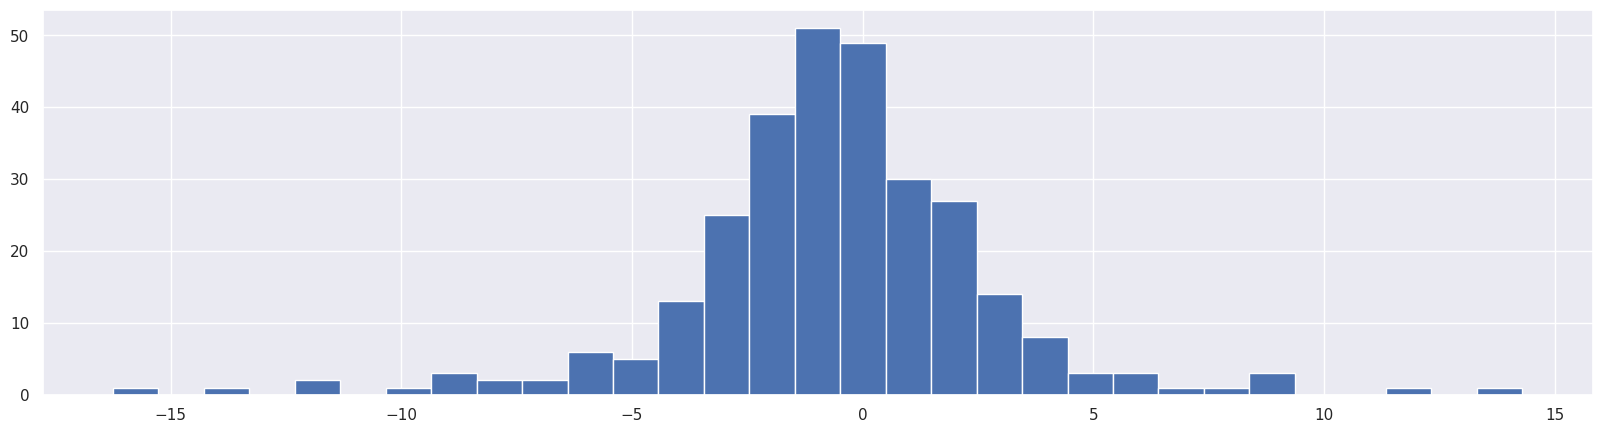

In [66]:
actual_vs_ohlcv_execution_df["buy_trade_slippage_bps"].unstack().hist(bins=31)

<AxesSubplot: >

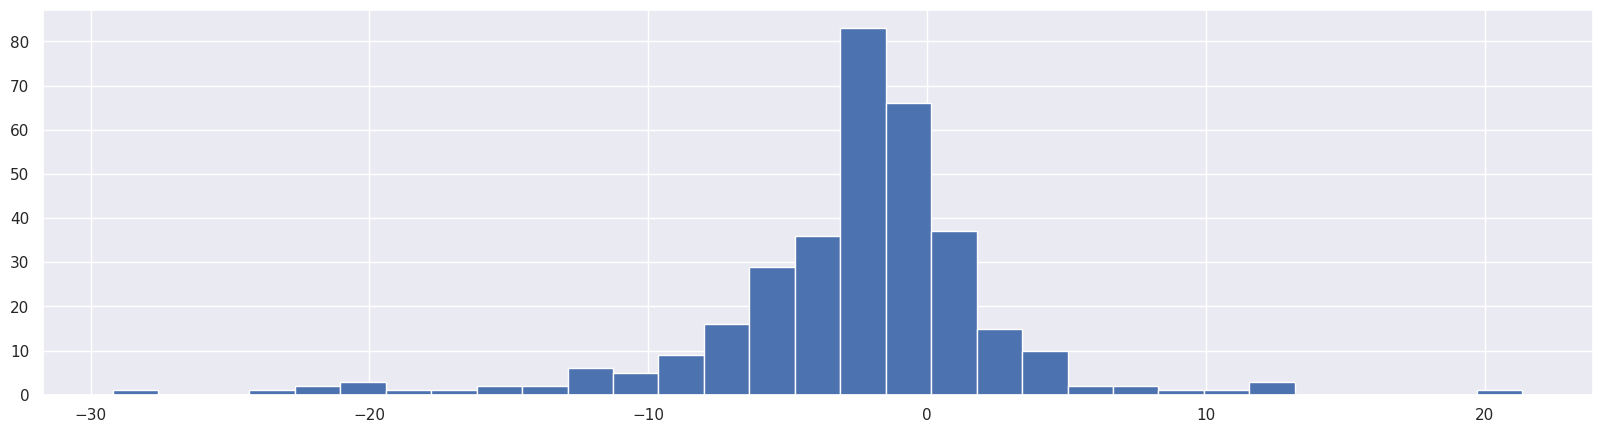

In [67]:
actual_vs_ohlcv_execution_df["sell_trade_slippage_bps"].unstack().hist(bins=31)

In [68]:
if execution_has_btc:
    omreconc.get_asset_slice(actual_and_ohlcv_price_df, btc_usdt_id).plot()

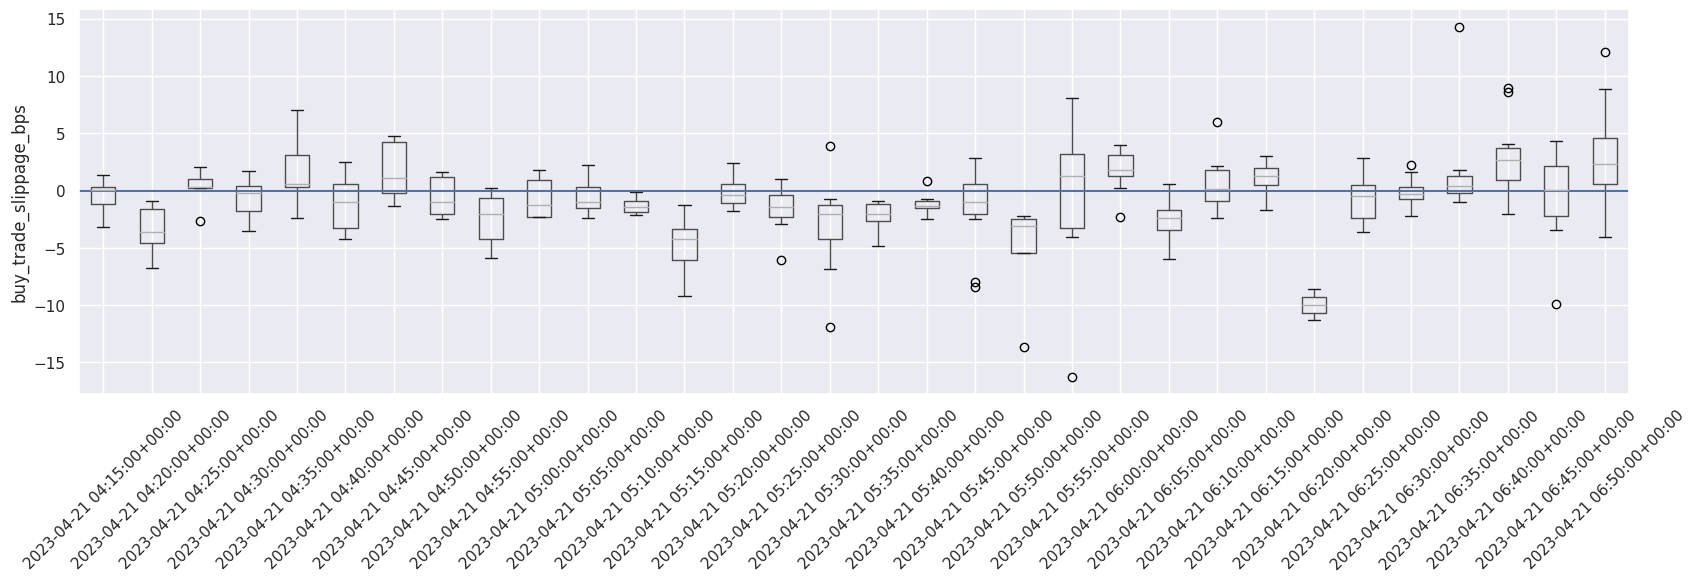

In [69]:
col = "buy_trade_slippage_bps"
coplotti.plot_slippage_boxplot(
    actual_vs_ohlcv_execution_df[col], "by_time", ylabel=col
)

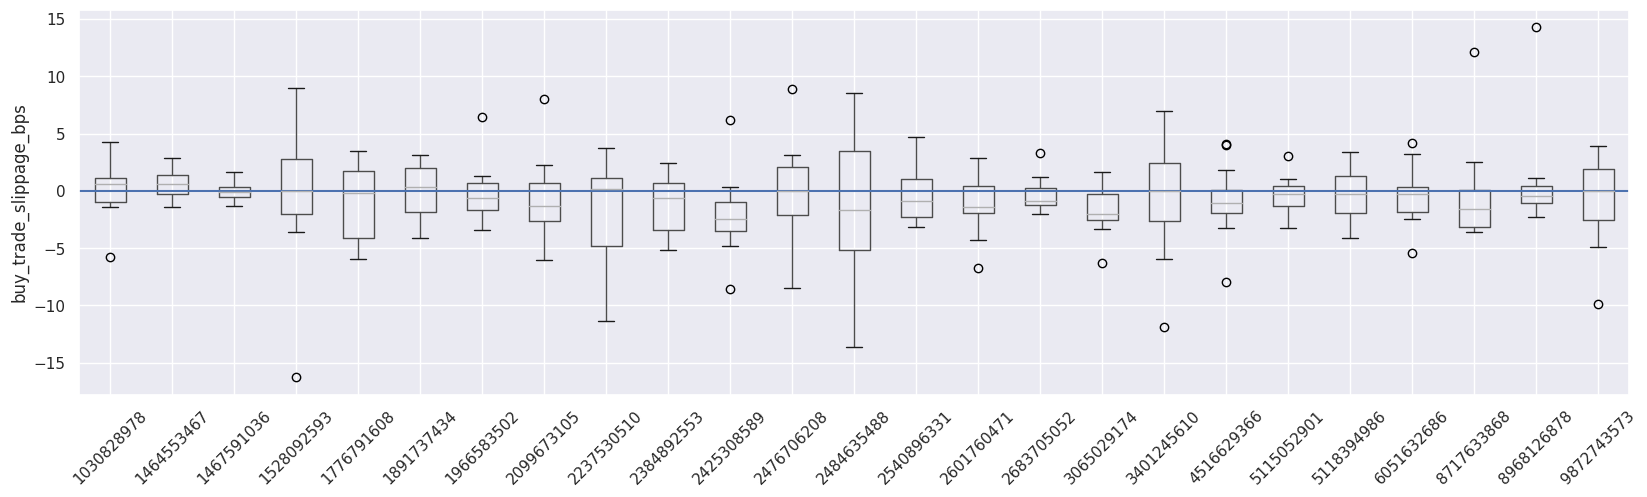

In [70]:
coplotti.plot_slippage_boxplot(
    actual_vs_ohlcv_execution_df[col], "by_asset", ylabel=col
)

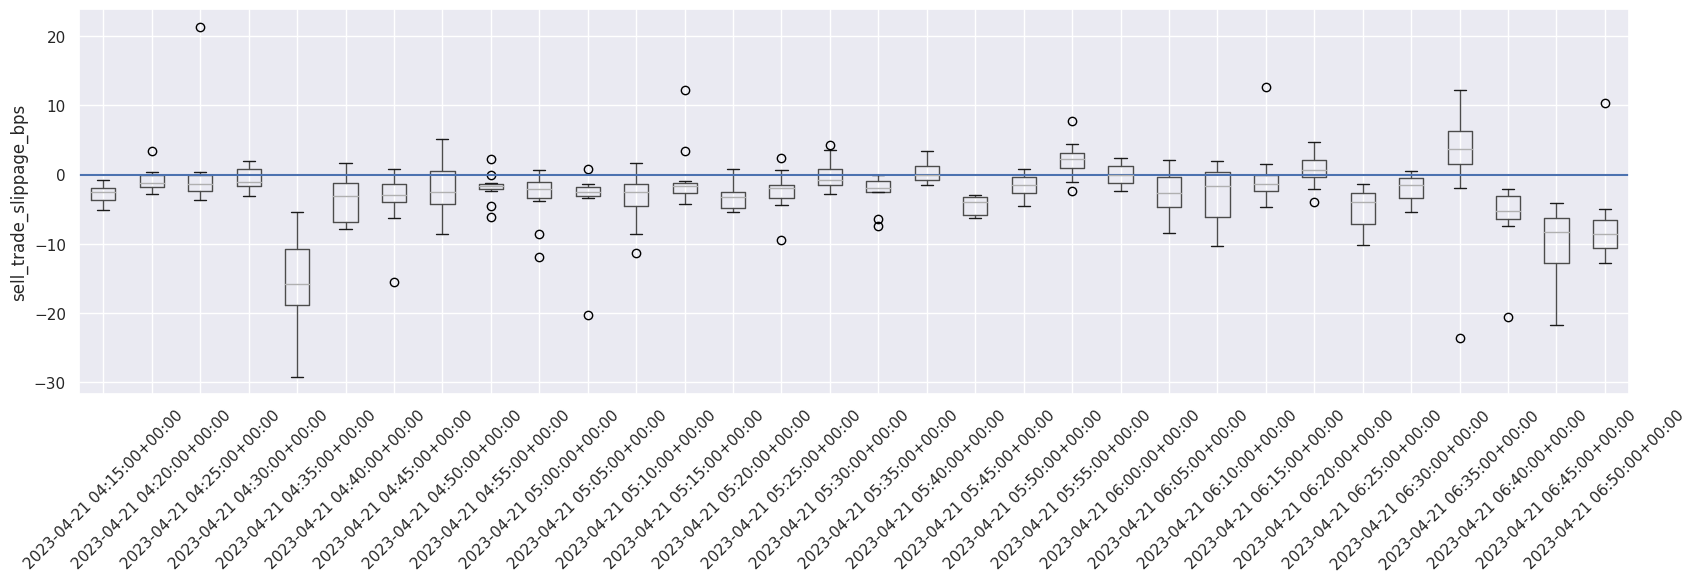

In [71]:
col = "sell_trade_slippage_bps"
coplotti.plot_slippage_boxplot(
    actual_vs_ohlcv_execution_df[col], "by_time", ylabel=col
)

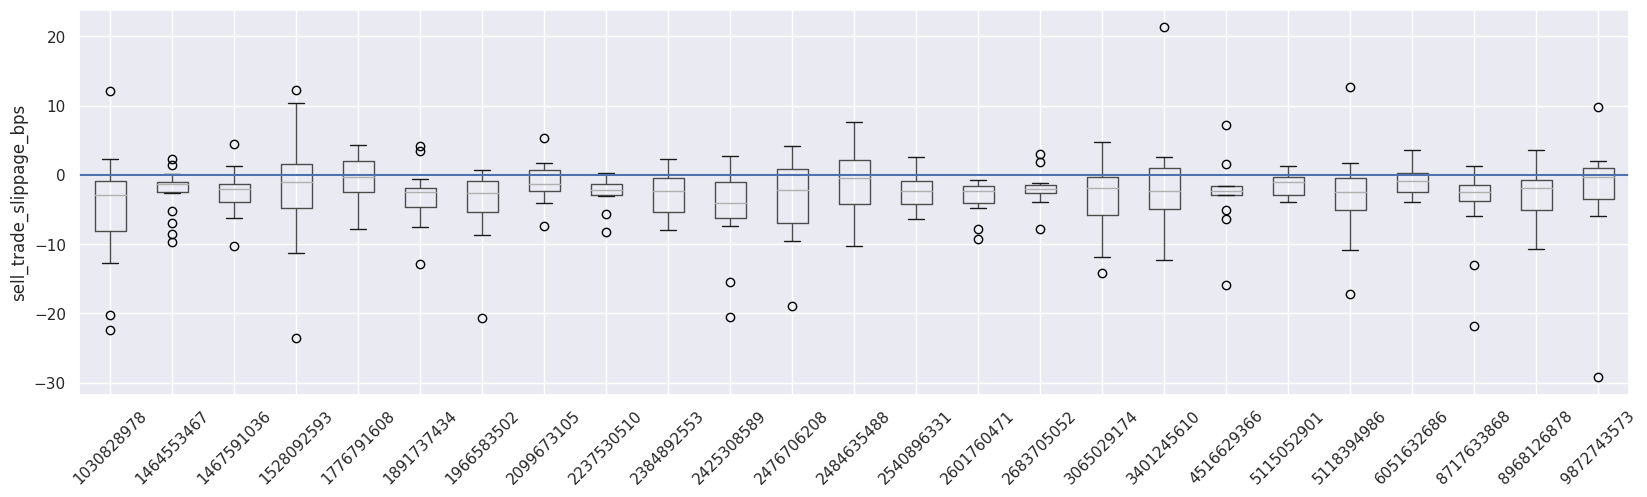

In [72]:
coplotti.plot_slippage_boxplot(
    actual_vs_ohlcv_execution_df[col], "by_asset", ylabel=col
)